Running experiments for Agents: (1, 2, 4, 8, 16)
Simulations per config: 100 | Max Steps: 500

Method=APF | Agents=1
  Completed 50/100
  Completed 100/100

Method=APF | Agents=2
  Completed 50/100
  Completed 100/100

Method=APF | Agents=4
  Completed 50/100
  Completed 100/100

Method=APF | Agents=8
  Completed 50/100
  Completed 100/100

Method=APF | Agents=16
  Completed 50/100
  Completed 100/100

Method=RANDOM | Agents=1
  Completed 50/100
  Completed 100/100

Method=RANDOM | Agents=2
  Completed 50/100
  Completed 100/100

Method=RANDOM | Agents=4
  Completed 50/100
  Completed 100/100

Method=RANDOM | Agents=8
  Completed 50/100
  Completed 100/100

Method=RANDOM | Agents=16
  Completed 50/100
  Completed 100/100


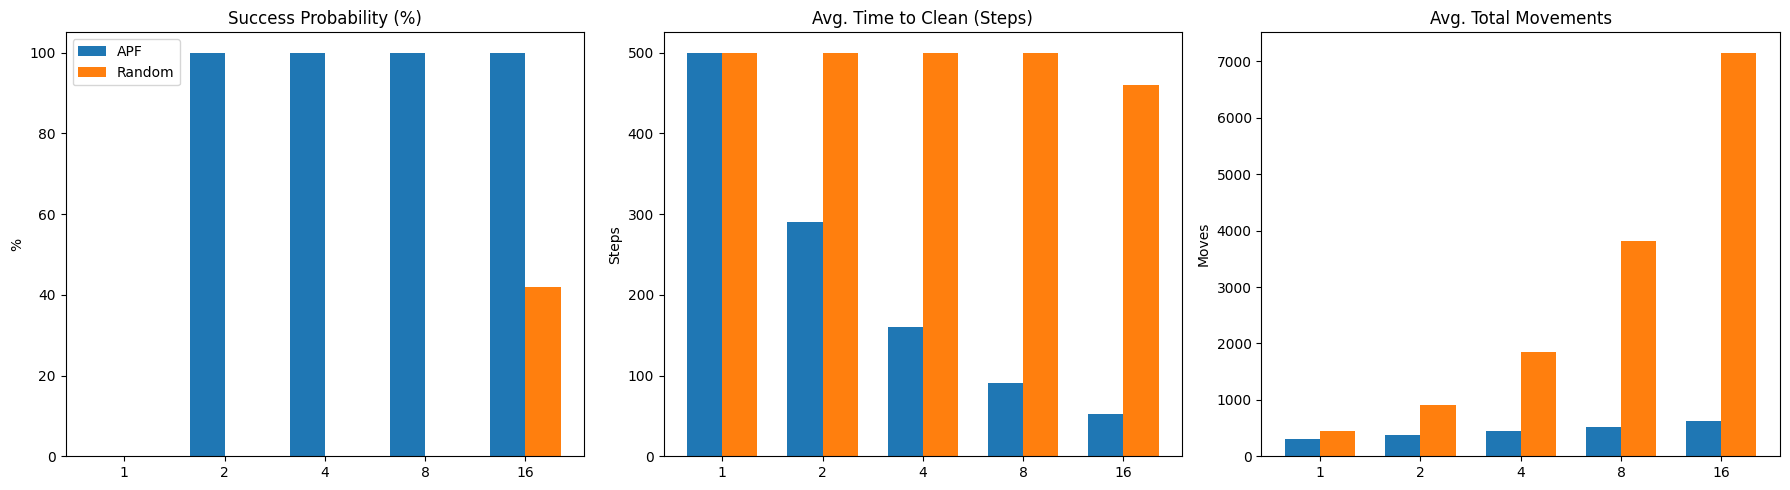


Table Fig1
Method | N  | Success(%) | Avg Steps | Avg Moves
APF    | 1  | 0.0        | 500.0     | 308.3    
APF    | 2  | 100.0      | 290.0     | 379.9    
APF    | 4  | 100.0      | 160.3     | 441.0    
APF    | 8  | 100.0      | 90.4      | 522.7    
APF    | 16 | 100.0      | 52.0      | 630.8    
RANDOM | 1  | 0.0        | 500.0     | 443.3    
RANDOM | 2  | 0.0        | 500.0     | 900.3    
RANDOM | 4  | 0.0        | 500.0     | 1850.5   
RANDOM | 8  | 0.0        | 500.0     | 3813.4   
RANDOM | 16 | 42.0       | 459.7     | 7156.9   
--- Start!!!! ---
Target: Clean 200 cells within 500 steps.
Running experiments for Agents: (1, 2, 4, 8, 16)
Simulations per config: 100 | Max Steps: 500

Method=APF | Agents=1
  Completed 50/100
  Completed 100/100

Method=APF | Agents=2
  Completed 50/100
  Completed 100/100

Method=APF | Agents=4
  Completed 50/100
  Completed 100/100

Method=APF | Agents=8
  Completed 50/100
  Completed 100/100

Method=APF | Agents=16
  Completed 50/100
  Co

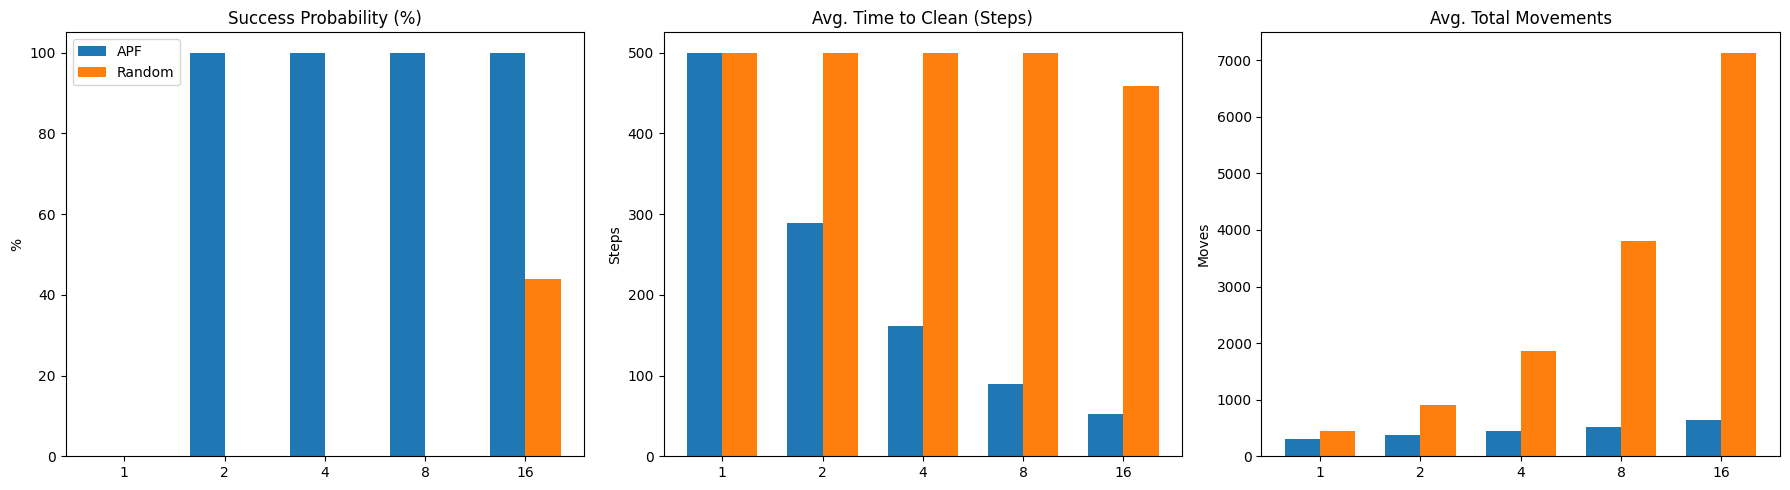

ValueError: too many values to unpack (expected 3)

In [15]:
"""
Cleaning Robots Multi-Agent Simulation
Integrantes:
  E. Aislinn Gil Orozco - A01666225
  Bastian Uribe Sánchez - A01666949

"""

import random
import numpy as np
import matplotlib.pyplot as plt
import mesa
from collections import defaultdict

# -------------------------
# Agent APF
class CleaningRobotAPF(mesa.Agent):
    def __init__(self, unique_id, model, k_att=1.0, k_rep=2.0, d0=3.0):
        super().__init__(unique_id, model)
        self.movements = 0
        self.k_att = k_att
        self.k_rep = k_rep
        self.d0 = d0

    def step(self):
        if self.model.grid_state[self.pos]:
            self.model.grid_state[self.pos] = False
            self.model.dirty_cells.discard(self.pos)
            return

        self.move_apf()

    def move_apf(self):
        f_att = self.attractive_force()
        f_rep = self.repulsive_force()
        f_total = f_att + f_rep

        if np.linalg.norm(f_total) > 0:
            new_pos = self.select_best_neighbor(f_total)
            if new_pos != self.pos:
                self.model.grid.move_agent(self, new_pos)
                self.movements += 1

    def attractive_force(self):
        if not self.model.dirty_cells:
            return np.array([0.0, 0.0])
        
        nearest_dirty = min(
            self.model.dirty_cells,
            key=lambda p: self.manhattan_distance(self.pos, p)
        )
        
        dx = nearest_dirty[0] - self.pos[0]
        dy = nearest_dirty[1] - self.pos[1]
        dist = max(np.sqrt(dx*dx + dy*dy), 0.1) 
        
        return self.k_att * np.array([dx/dist, dy/dist])

    def repulsive_force(self):
        f_rep = np.array([0.0, 0.0])
        neighbors = self.model.grid.get_neighbors(
            self.pos, moore=True, include_center=False, radius=int(self.d0)
        )
        for other in neighbors:
            if isinstance(other, CleaningRobotAPF):
                dx = self.pos[0] - other.pos[0]
                dy = self.pos[1] - other.pos[1]
                dist = max(np.sqrt(dx*dx + dy*dy), 0.1)
                
                if dist < self.d0:
                    magnitude = self.k_rep * (1.0/dist - 1.0/self.d0) * (1.0/dist**2)
                    f_rep += magnitude * np.array([dx/dist, dy/dist])
        return f_rep

    def select_best_neighbor(self, force_vec):
        neighbors = self.model.grid.get_neighborhood(self.pos, moore=True, include_center=True)
        best_pos = self.pos
        best_score = -float("inf")
        
        for cell in neighbors:
            dx = cell[0] - self.pos[0]
            dy = cell[1] - self.pos[1]
            vec = np.array([dx, dy])
            norm = np.linalg.norm(vec)
            
            if norm > 0:
                score = np.dot(force_vec, vec / norm) 
                if score > best_score:
                    best_score = score
                    best_pos = cell
        return best_pos

    @staticmethod
    def manhattan_distance(a, b):
        return abs(a[0] - b[0]) + abs(a[1] - b[1])


class CleaningRobotRandom(mesa.Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.movements = 0

    def step(self):
        if self.model.grid_state[self.pos]:
            self.model.grid_state[self.pos] = False
            self.model.dirty_cells.discard(self.pos)
            return

        neighbors = self.model.grid.get_neighborhood(self.pos, moore=True, include_center=False)
        if neighbors:
            new_pos = random.choice(neighbors)
            self.model.grid.move_agent(self, new_pos)
            self.movements += 1


class CleaningModel(mesa.Model):
    def __init__(self, width=20, height=30, n_agents=5, n_dirty=200, max_steps=500, agent_type="apf"):
        super().__init__()
        self.width = width
        self.height = height
        self.n_agents = n_agents
        self.n_dirty = n_dirty
        self.max_steps = max_steps
        self.agent_type = agent_type 

        self.current_step = 0
        self.running = True

        self.schedule = mesa.time.RandomActivation(self)
        self.grid = mesa.space.MultiGrid(width, height, torus=False)

        # Track dirty cells
        self.grid_state = defaultdict(bool)
        self.dirty_cells = set()

        all_cells = [(x, y) for x in range(width) for y in range(height)]
        
        if n_dirty > len(all_cells):
            raise ValueError("n_dirty cannot exceed ttl cells")
            
        dirty_positions = random.sample(all_cells, n_dirty)
        for pos in dirty_positions:
            self.grid_state[pos] = True
            self.dirty_cells.add(pos)

        clean_cells = [c for c in all_cells if c not in dirty_positions]
        if len(clean_cells) < n_agents:
            raise ValueError("Not enough clean cells")
            
        start_positions = random.sample(clean_cells, n_agents)

        for i, pos in enumerate(start_positions):
            if self.agent_type == "apf":
                bot = CleaningRobotAPF(i, self)
            else:
                bot = CleaningRobotRandom(i, self)
            self.schedule.add(bot)
            self.grid.place_agent(bot, pos)

    def step(self):
        self.current_step += 1
        self.schedule.step()

        if not self.dirty_cells or self.current_step >= self.max_steps:
            self.running = False

    def run_simulation(self):
        self.running = True
        self.current_step = 0
        while self.running:
            self.step()

        cleaned = self.n_dirty - len(self.dirty_cells)
        percent_cleaned = (cleaned / self.n_dirty) * 100.0
        total_moves = sum(getattr(a, "movements", 0) for a in self.schedule.agents)
        
        # Success condition: All dirty cells cleaned AND within time limit
        success = (len(self.dirty_cells) == 0) and (self.current_step <= self.max_steps)
        
        return {
            "success": success,
            "steps": self.current_step,
            "cleaned": cleaned,
            "percent_cleaned": percent_cleaned,
            "movements": total_moves,
        }


def run_comparative_experiments(n_simulations=100, agent_counts=(1, 2, 4, 8, 16), n_dirty=200, max_steps=500):
    methods = ["apf", "random"]
    results = {m: {n: [] for n in agent_counts} for m in methods}

    print(f"Running experiments for Agents: {agent_counts}")
    print(f"Simulations per config: {n_simulations} | Max Steps: {max_steps}")
    
    for method in methods:
        for n_agents in agent_counts:
            print(f"\nMethod={method.upper()} | Agents={n_agents}")
            for sim in range(n_simulations):
                model = CleaningModel(width=20, height=30, n_agents=n_agents, 
                                      n_dirty=n_dirty, max_steps=max_steps, agent_type=method)
                r = model.run_simulation()
                results[method][n_agents].append(r)
                if (sim + 1) % 50 == 0: print(f"  Completed {sim+1}/{n_simulations}")

    success_rates = {m: {n: sum(1 for res in results[m][n] if res["success"]) / n_simulations * 100
                         for n in agent_counts} for m in methods}

    avg_steps = {m: {n: np.mean([r["steps"] for r in results[m][n]]) for n in agent_counts} for m in methods}
    avg_moves = {m: {n: np.mean([r["movements"] for r in results[m][n]]) for n in agent_counts} for m in methods}

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    labels = [str(n) for n in agent_counts]
    x = np.arange(len(labels))
    width = 0.35

    #succesrate
    ax = axes[0]
    apf_s = [success_rates["apf"][n] for n in agent_counts]
    rnd_s = [success_rates["random"][n] for n in agent_counts]
    ax.bar(x - width/2, apf_s, width, label='APF')
    ax.bar(x + width/2, rnd_s, width, label='Random')
    ax.set_title('Success Probability (%)')
    ax.set_ylabel('%')
    ax.set_xticks(x); ax.set_xticklabels(labels)
    ax.set_ylim(0, 105)
    ax.legend()

    #Avg time
    ax = axes[1]
    apf_t = [avg_steps["apf"][n] for n in agent_counts]
    rnd_t = [avg_steps["random"][n] for n in agent_counts]
    ax.bar(x - width/2, apf_t, width, label='APF')
    ax.bar(x + width/2, rnd_t, width, label='Random')
    ax.set_title('Avg. Time to Clean (Steps)')
    ax.set_ylabel('Steps')
    ax.set_xticks(x); ax.set_xticklabels(labels)

    #avgv movs
    ax = axes[2]
    apf_m = [avg_moves["apf"][n] for n in agent_counts]
    rnd_m = [avg_moves["random"][n] for n in agent_counts]
    ax.bar(x - width/2, apf_m, width, label='APF')
    ax.bar(x + width/2, rnd_m, width, label='Random')
    ax.set_title('Avg. Total Movements')
    ax.set_ylabel('Moves')
    ax.set_xticks(x); ax.set_xticklabels(labels)

    plt.tight_layout()
    plt.show()

    return results, success_rates, avg_steps, avg_moves

if __name__ == "__main__":
    # Usar tus parámetros
    N_DIRTY = 200        
    MAX_STEPS = 500      
    AGENT_COUNTS = (1, 2, 4, 8, 16) 
    N_SIMS = 100         

    res, rates, steps, moves = run_comparative_experiments(
        n_simulations=N_SIMS, agent_counts=AGENT_COUNTS, n_dirty=N_DIRTY, max_steps=MAX_STEPS
    )
    
    print("\nTable Fig1")
    print("Method | N  | Success(%) | Avg Steps | Avg Moves")
    for m in ["apf", "random"]:
        for n in AGENT_COUNTS:
            print(f"{m.upper():<6} | {n:<2} | {rates[m][n]:<10.1f} | {steps[m][n]:<9.1f} | {moves[m][n]:<9.1f}")

    print("--- Start!!!! ---")
    print(f"Target: Clean {N_DIRTY} cells within {MAX_STEPS} steps.")
    
    res, rates, summary = run_comparative_experiments(
        n_simulations=N_SIMS,
        agent_counts=AGENT_COUNTS,
        n_dirty=N_DIRTY,
        max_steps=MAX_STEPS
    )
    
    print("\nFianl results")
    for method in rates:
        print(f"\n>>> Method: {method.upper()}")
        print(f"{'Agents':<8} | {'Success %':<10} | {'Avg Steps':<10} | {'% Cleaned':<10}")
        print("-" * 45)
        for n in AGENT_COUNTS:
            s_rate = rates[method][n] * 100
            steps = summary[method][n]['avg_steps']
            p_clean = summary[method][n]['avg_percent']
            print(f"{n:<8} | {s_rate:<10.1f} | {steps:<10.1f} | {p_clean:<10.1f}")
